In [2]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
import warnings
from pytorch_lightning.callbacks import EarlyStopping
warnings.filterwarnings('ignore')

# Functions

## Plotting

In [3]:
def plot_graph(df, x_col = "Date", y_col = "Close", title = "S&P 500",
                        xlabel = 'Year', ylabel = 'Close value', start = "", end = ""):
    plt.figure(figsize=(10, 7))
    plt.plot(df[x_col], df[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    plt.show()
    return df

def plot_diff_series(df, x_col = "Date", y_col = "Log_Close", periods=365, xlabel= "Year", ylabel = 'Close value change',
                    title = "Differentiated Series Yearly"):
    df_diff = df.copy()
    df_diff = df_diff.set_index(x_col)
    df_diff=df_diff.diff(periods=periods)
    df_diff=df_diff.dropna() 

    plt.figure(figsize=(10, 7))
    plt.plot(df_diff.index, df_diff[y_col])
    plt.title(title,fontsize=15)
    plt.xlabel(xlabel, fontsize=10)
    plt.ylabel(ylabel, fontsize=10)
    return df_diff

def decompose_time_series(df, x_col = "Date", y_col = "Log_Close", period = 365):
    decomposition = seasonal_decompose(df[y_col], model='additive', period=period)

    plt.figure(figsize=(10, 7))

    plt.subplot(411)
    plt.plot(df[x_col],df[y_col], label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Series')

    plt.subplot(412)
    plt.plot(df[x_col],decomposition.trend, label='Trend')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(413)
    plt.plot(df[x_col],decomposition.seasonal, label='Seasonality')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(414)
    plt.plot(df[x_col],decomposition.resid, label='Residuals')
    plt.legend(loc='upper left')
    plt.title('Residual Component')

    plt.tight_layout()
    plt.show()
    df_out = pd.DataFrame({"Date": df["Date"], "seasonal": decomposition.seasonal,
                          "trend": decomposition.trend, "resid":decomposition.resid})
    return df_out

def plot_org_w_pred(data):
    ax = data["Log_Close"].plot(label='Observed', figsize=(10, 5))
    data["Forecast"].plot(ax=ax, label='Forecast', legend=True)
    plt.legend()
    plt.show()

## Processing

In [4]:
def make_full_dates_df(sp500):
    full_sp500 = pd.DataFrame({
        "Date": pd.date_range(sp500["Date"].iloc[0], sp500["Date"].iloc[-1], freq="D")
    })
    
    full_sp500 = full_sp500.merge(sp500, on="Date", how="left")
    full_sp500["Open"].ffill(inplace=True)
    full_sp500["Close"].ffill(inplace=True)
    full_sp500["Adj Close"].ffill(inplace=True)
    full_sp500["Volume"].fillna(0, inplace=True)
    full_sp500["Low"].fillna(full_sp500["Close"], inplace=True)
    full_sp500["High"].fillna(full_sp500["Close"], inplace=True)
    
    return full_sp500

## SARIMA

In [194]:
def forecast_with_sarimax(time_series, forecast_periods, order, seasonal_order, xlabel = 'Year',
                          ylabel = 'Log Close Price', freq='W-MON', plot=True, offset = 0, title = "", forcast_next = False):
    if forcast_next:
        sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    else:
        sarima_model = SARIMAX(time_series[:-forecast_periods - offset], order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    next_periods_forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
    next_periods_ci = next_periods_forecast.conf_int()
    
    if forcast_next:
        future_dates = pd.date_range(start=time_series.index[-1], periods=forecast_periods, freq=freq)
    else:
        future_dates = pd.date_range(start=time_series.index[-forecast_periods - offset], periods=forecast_periods, freq=freq)
    next_periods_ci.index = future_dates

    futureDF_forecast = pd.DataFrame(next_periods_forecast.predicted_mean, index=future_dates)

    if plot:
        if offset == 0:
            ax = time_series.plot(label='Observed', figsize=(10, 5))
        else:
            ax = time_series[:-offset].plot(label='Observed', figsize=(10, 5))
        futureDF_forecast.plot(ax=ax, label='Forecast', legend=True)
        
        ax.fill_between(next_periods_ci.index,
                        next_periods_ci.iloc[:, 0],
                        next_periods_ci.iloc[:, 1], color='k', alpha=.1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        plt.legend()
        plt.show()
    return futureDF_forecast, next_periods_ci

def sarima_obs_vs_pred(time_series, order, seasonal_order, xlabel='Date', ylabel='Value', plot=True, title='Observed vs Predicted'):
    sarima_model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)

    predictions = sarima_model_fit.get_prediction(start=time_series.index[0], end=time_series.index[-1])
    predictions_summary = predictions.summary_frame()

    if plot:
        plt.figure(figsize=(12, 8))
        ax = plt.gca() 
        ax.scatter(time_series.index[12:], time_series[12:], color='black', label='Observed', s=10, alpha=0.4)
        ax.plot(predictions_summary.index[12:], predictions_summary['mean'][12:], label='Predicted',
                alpha=0.6, color='skyblue', linewidth=1)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim((2.5,8.5))
        plt.legend()
        plt.show()

In [267]:
def get_sarima_mse(time_series, order, seasonal_order, start_pred_point = "2019-11-06",
                   prediction_period = 52, y_col= 'Log_Close', exog=None):
    train_data = time_series[time_series["Date"] < start_pred_point][y_col]
    if not isinstance(exog, type(None)):
        exog_train = exog[time_series["Date"] < start_pred_point]
        exog_test = exog[time_series["Date"] > start_pred_point]
    else:
        exog_train = None
        exog_test = None
        
    sarima_model = SARIMAX(train_data, exog = exog_train, order=order, seasonal_order=seasonal_order)
    sarima_model_fit = sarima_model.fit(disp=False)
    
    next_periods_forecast = sarima_model_fit.get_forecast(steps=prediction_period, exog = exog_test[:prediction_period]).predicted_mean
    next_periods_true = time_series[time_series["Date"] > start_pred_point][y_col][:prediction_period]
    
    mse_score = mean_squared_error(next_periods_forecast, next_periods_true)
    aic_score = sarima_model_fit.aic
    return mse_score, aic_score

def cross_validate_sarima(time_series, cutoffs, order, seasonal_order, prediction_period = 52,
                          y_col= 'Log_Close', exog=None):
    mse_results = []
    aic_results = []
    for i, cutoff in enumerate(cutoffs):
        print(f"Starting fold {i+1}/{len(cutoffs)}", end="\r")
        mse, aic = get_sarima_mse(time_series, order, seasonal_order, cutoff, prediction_period, y_col, exog)
        mse_results.append(mse)
        aic_results.append(aic)
    return mse_results, np.mean(mse_results), aic_results, np.mean(aic_results)

def hyper_tune_sarima(monthly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
                      name='sarima_hyperparameters_weekly.csv'):
    results = []
    parma_grid = product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values)
    n_sets = len(list(parma_grid))
    i = 0
    for (p, d, q, P, D, Q, s) in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
        i+=1
        print(f"params set {i}: {(i)/(n_sets)*100: .1f} %")
        order = (p, d, q)
        seasonal_order = (P, D, Q, s)
        try:
            _, avg_mse, _, avg_aic = cross_validate_sarima(monthly_data, cutoffs, order, seasonal_order)
            print(f"Order={order}, Seasonal_Order={seasonal_order}, MSE={avg_mse}, AIC={avg_aic}")
            results.append((order, seasonal_order, avg_mse, avg_aic))
        except Exception as e:
            print(f"Failed for order={order}, seasonal_order={seasonal_order}. Error: {e}")
            results.append((order, seasonal_order, float('inf'), float('inf')))
    
    df = pd.DataFrame(results, columns=['Order', 'Seasonal_Order', 'MSE', 'AIC'])
    df.to_csv(name, index=False)
    return df

In [7]:
# def get_sarima_mse(time_series, order, seasonal_order, start_pred_point = "2019-11-06",
#                        prediction_period = 52, y_col= 'Log_Close'):
#     train_data = time_series[time_series["Date"]<start_pred_point][y_col]
    
#     sarima_model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
#     sarima_model_fit = sarima_model.fit(disp=False)

#     next_periods_forecast = sarima_model_fit.get_forecast(steps=prediction_period).predicted_mean
#     next_periods_true = time_series[time_series["Date"]>start_pred_point][y_col][:prediction_period]
#     mse_score = mean_squared_error(next_periods_forecast, next_periods_true)
#     return mse_score

# def cross_validate_sarima(time_series, cutoffs, order, seasonal_order, prediction_period = 52, y_col= 'Log_Close'):
#     folds_res = []
#     for i, cutoff in enumerate(cutoffs):
#         print(f"starting fold {i+1}/{len(cutoffs)}", end = "\r")
#         folds_res.append(get_sarima_mse(time_series, order, seasonal_order, cutoff, prediction_period, y_col))
#     return folds_res, np.mean(folds_res)

# def hyper_tune_sarima(monthly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
#                      name='sarima_hyperparameters_weekly.csv'):
#     results = []
#     for (p, d, q, P, D, Q, s) in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
#         order = (p, d, q)
#         seasonal_order = (P, D, Q, s)
#         try:
#             score = cross_validate_sarima(monthly_data, cutoffs, order, seasonal_order)[1]
#         except:
#             print("failed")
#             score = 1
#         print(f"order={order}, seasonal_order={seasonal_order}, score={score}")
#         results.append((order, seasonal_order, score))
#     df = pd.DataFrame(results, columns=['Order', 'Seasonal_Order', 'Score'])
#     df.to_csv(name, index=False)
#     return df


## Prophet

In [9]:
def hyper_tune_prophet_model(df, cutoffs, param_grid):
    all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    mses = []

    for params in all_params:
        m = Prophet(**params).fit(df)
        df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
        df_p = performance_metrics(df_cv, rolling_window=1)
        mses.append(df_p['mse'].values[0])

    tuning_results = pd.DataFrame(all_params)
    tuning_results['mse'] = mses
    
    return tuning_results

## Elections

In [181]:
def years_until_next_election(year):
    return (4 - (year % 4)) % 4

def fill_party_periods(periods, party):
    return {year: party for start, end in periods for year in range(start, end)}

def generate_presidential_parties():
    democrat_periods = [(1940, 1952), (1961, 1969), (1977, 1981), (1993, 2001), (2009, 2017), (2021, 2024)]
    republican_periods = [(1953, 1961), (1969, 1977), (1981, 1993), (2001, 2009), (2017, 2021)]
    parties = {}
    parties.update(fill_party_periods(democrat_periods, 'Democrat'))
    parties.update(fill_party_periods(republican_periods, 'Republican'))
    return parties

def generate_president_party_dataset(last_year=2023):
    presidential_parties = generate_presidential_parties()
    start_date = '1940-01-01'
    end_date = f'{last_year}-12-31'
    dates = pd.date_range(start=start_date, end=end_date, freq='D')

    data = {'Date': [], 'Years Until Next US Election': [], 'Presidential Party': []}
    for date in dates:
        year = date.year
        party = presidential_parties.get(year, 'Unknown')
        data['Date'].append(date)
        data['Years Until Next US Election'].append(years_until_next_election(year))
        data['Presidential Party'].append(party)
    
    df = pd.DataFrame(data)
    return df

# Data loading

In [10]:
sp500 = pd.read_csv("SPY1950.csv")
sp500["Date"] = pd.to_datetime(sp500["Date"], format = "%d/%m/%Y")
sp500 = make_full_dates_df(sp500)
sp500["Log_Close"] = np.log(sp500["Close"])

In [11]:
sp500.tail(5)

Date         Open         High          Low        Close  \
25869 2020-10-31  3293.590088  3269.959961  3269.959961  3269.959961   
25870 2020-11-01  3293.590088  3269.959961  3269.959961  3269.959961   
25871 2020-11-02  3296.199951  3330.139893  3279.739990  3310.239990   
25872 2020-11-03  3336.250000  3389.489990  3336.250000  3369.159912   
25873 2020-11-04  3406.459961  3486.250000  3405.169922  3443.439941   

         Adj Close        Volume  Log_Close  
25869  3269.959961  0.000000e+00   8.092533  
25870  3269.959961  0.000000e+00   8.092533  
25871  3310.239990  4.310590e+09   8.104776  
25872  3369.159912  4.220070e+09   8.122419  
25873  3443.439941  4.783040e+09   8.144226

In [12]:
weekly_data = sp500[sp500["Date"].dt.dayofweek == 0]
weekly_data.reset_index(inplace = True, drop = True)
weekly_data["Log_Close"] = np.log(weekly_data["Close"])

# Plotting the data

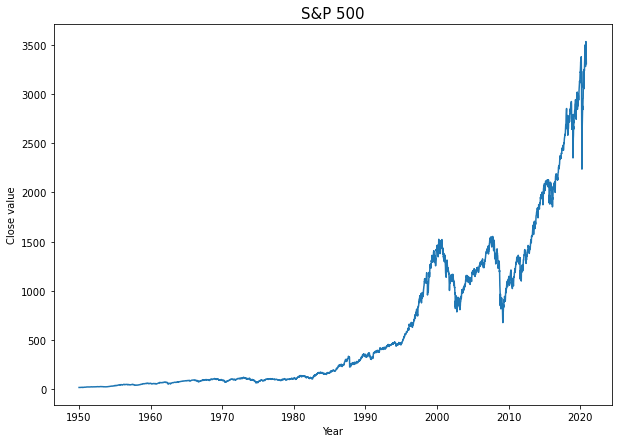

In [13]:
plot_graph(weekly_data);

this graph is rather exponential, lets take a look at the Log Close value

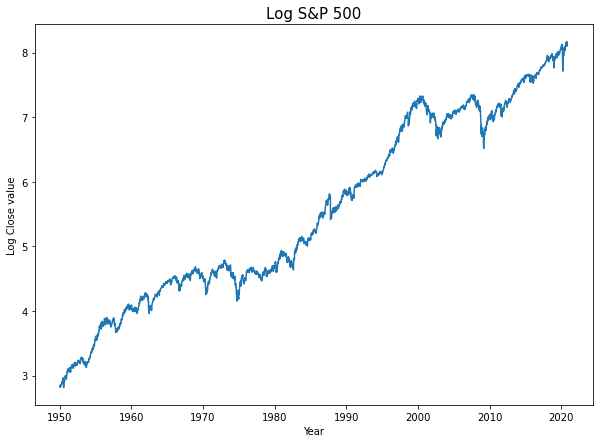

In [14]:
plot_graph(weekly_data, y_col= "Log_Close", ylabel = "Log Close value" , title = "Log S&P 500");

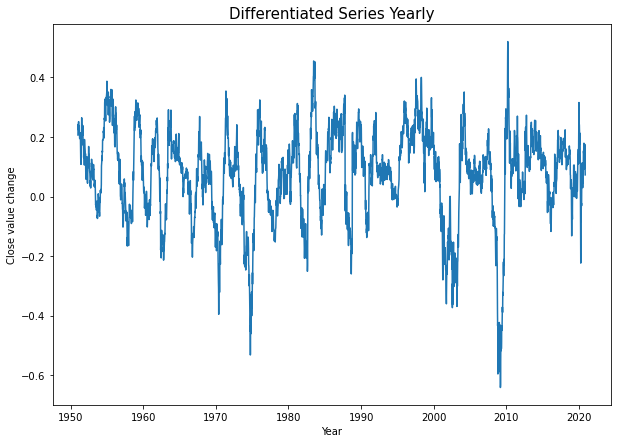

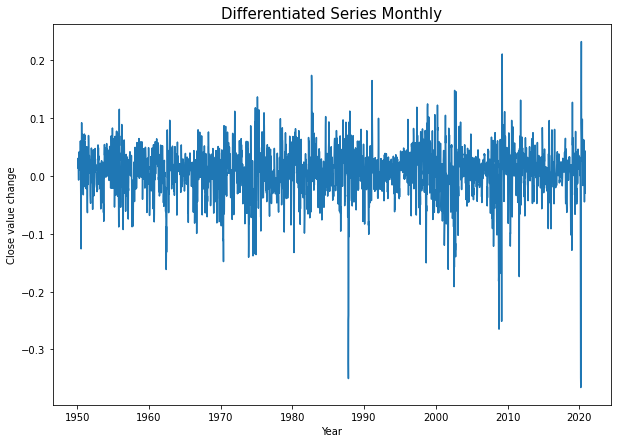

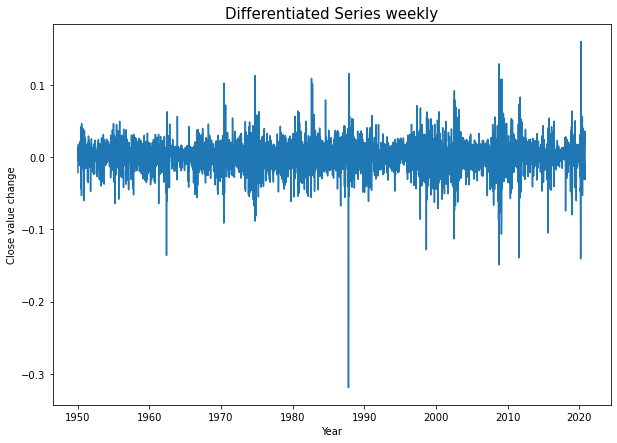

In [15]:
weekly_data_diff_Y = plot_diff_series(weekly_data, periods = 52)
weekly_data_diff_M = plot_diff_series(weekly_data, periods = 4, title = "Differentiated Series Monthly")
weekly_data_diff_W = plot_diff_series(weekly_data, periods = 1, title = "Differentiated Series weekly")

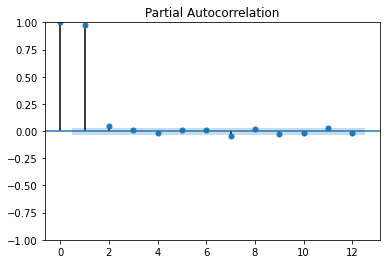

In [16]:
tsaplots.plot_pacf(weekly_data_diff_Y["Log_Close"], lags=12);

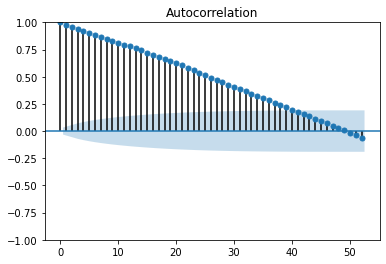

In [17]:
tsaplots.plot_acf(weekly_data_diff_Y["Log_Close"], lags=52);

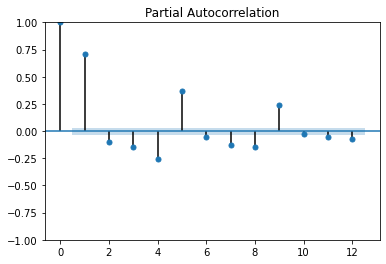

In [18]:
tsaplots.plot_pacf(weekly_data_diff_M["Log_Close"], lags=12);

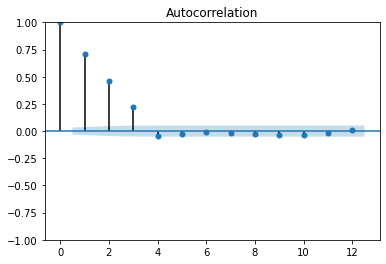

In [19]:
tsaplots.plot_acf(weekly_data_diff_M["Log_Close"], lags=12);

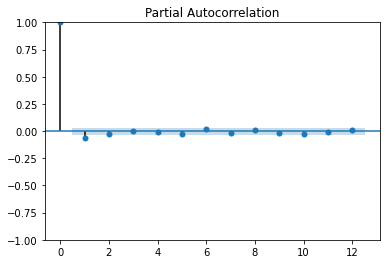

In [20]:
tsaplots.plot_pacf(weekly_data_diff_W["Log_Close"], lags=12);

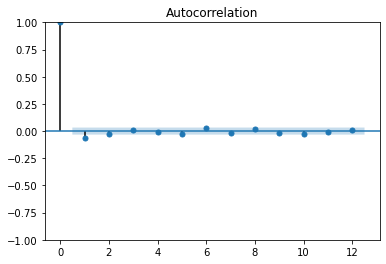

In [21]:
tsaplots.plot_acf(weekly_data_diff_W["Log_Close"], lags=12);

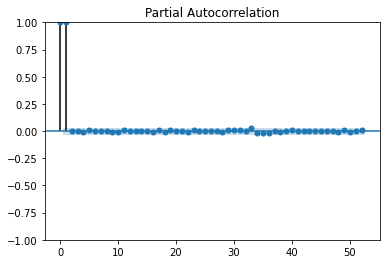

In [22]:
tsaplots.plot_pacf(weekly_data["Log_Close"], lags=52);

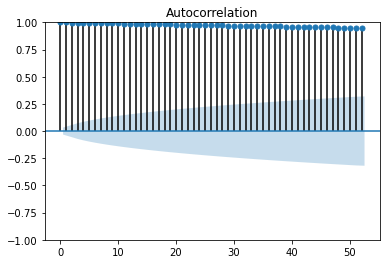

In [23]:
tsaplots.plot_acf(weekly_data["Log_Close"], lags=52);

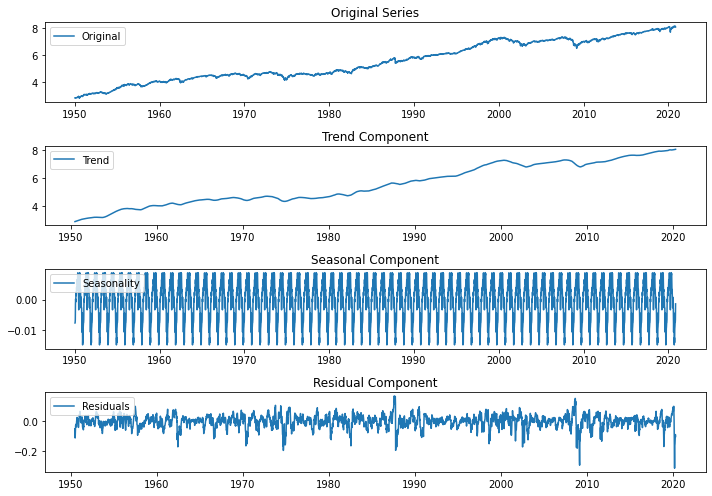

In [105]:
decomposition_year_weekly = decompose_time_series(weekly_data, y_col = "Log_Close", period = 52)

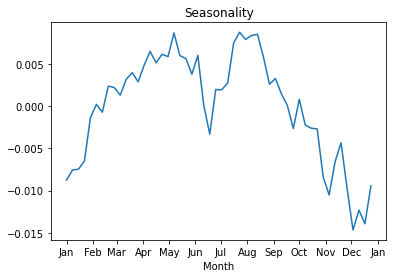

In [106]:
plt.plot(decomposition_year_weekly["Date"][51:103],decomposition_year_weekly["seasonal"][51:103])
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.xlabel("Month")
plt.title("Seasonality")
plt.plot();

# Modeling

## SARIMA (weekly)

In [26]:
cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])

In [27]:
# p_values = [1, 2,3]
# d_values = [0, 1]
# q_values = [0, 1, 2]
# P_values = [0, 1,2,3]
# D_values = [1,2,3,4]
# Q_values = [1,2,3,4]
# s_values = [4]
# hyper_tune_sarima(weekly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
#                   name='sarima_hyperparameters_weekly_52.csv')

# # order=(1, 0, 1), seasonal_order=(0, 2, 4, 4), score=0.006603962916601991
# # order=(2, 0, 0), seasonal_order=(0, 2, 4, 4), score=0.0066995197647212405
# # order=(1, 0, 0), seasonal_order=(1, 2, 4, 4), score=0.007465368522462384
# # order=(1, 0, 1), seasonal_order=(1, 2, 4, 4), score=0.00799524648792118
# # order=(1, 1, 2), seasonal_order=(3, 1, 1, 4), score=0.007941594015737855



In [226]:
# cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
# p_values = [1, 2,3]
# d_values = [0, 1]
# q_values = [0, 1, 2]
# P_values = [0, 1,2,3]
# D_values = [1,2,3,4]
# Q_values = [1,2,3,4]
# s_values = [4]
# hyper_tune_sarima(weekly_data, cutoffs, p_values, d_values, q_values, P_values, D_values, Q_values, s_values,
#                   name='sarima_hyperparameters_weekly_52.csv')

params set 1:  0.1
Order=(1, 0, 0), Seasonal_Order=(0, 1, 1, 4), MSE=0.013594899464413394, AIC=-9859.838799050125
params set 2:  0.2
Order=(1, 0, 0), Seasonal_Order=(0, 1, 2, 4), MSE=0.014502684081478989, AIC=-9859.112728068203
params set 3:  0.3
Order=(1, 0, 0), Seasonal_Order=(0, 1, 3, 4), MSE=0.014206184642381539, AIC=-9858.045133414902
params set 4:  0.3
Order=(1, 0, 0), Seasonal_Order=(0, 1, 4, 4), MSE=0.01633758120835019, AIC=-9843.004456750332
params set 5:  0.4
Order=(1, 0, 0), Seasonal_Order=(0, 2, 1, 4), MSE=0.008829370869162878, AIC=-8756.97742869522
params set 6:  0.5
Order=(1, 0, 0), Seasonal_Order=(0, 2, 2, 4), MSE=0.016028053541712058, AIC=-9777.09884269911
params set 7:  0.6
Order=(1, 0, 0), Seasonal_Order=(0, 2, 3, 4), MSE=0.014034009761742216, AIC=-9771.08996585091
params set 8:  0.7
Order=(1, 0, 0), Seasonal_Order=(0, 2, 4, 4), MSE=0.013058082141802207, AIC=-9790.405904614414
params set 9:  0.8
Order=(1, 0, 0), Seasonal_Order=(0, 3, 1, 4), MSE=0.22826506202845293, AI

Order=(1, 0, 1), Seasonal_Order=(0, 3, 1, 4), MSE=0.23591378467268315, AIC=-7432.056292618516
params set 74:  6.4
Order=(1, 0, 1), Seasonal_Order=(0, 3, 2, 4), MSE=0.06518262194630545, AIC=-8753.454186554878
params set 75:  6.5
Order=(1, 0, 1), Seasonal_Order=(0, 3, 3, 4), MSE=0.3598220197557205, AIC=-8659.030122942102
params set 76:  6.6
Order=(1, 0, 1), Seasonal_Order=(0, 3, 4, 4), MSE=0.24936344925666618, AIC=-8706.123877334847
params set 77:  6.7
Order=(1, 0, 1), Seasonal_Order=(0, 4, 1, 4), MSE=2.3403638200648005, AIC=-7219.853379188047
params set 78:  6.8
Order=(1, 0, 1), Seasonal_Order=(0, 4, 2, 4), MSE=1.8097419566748225, AIC=-8271.836171434761
params set 79:  6.9
Order=(1, 0, 1), Seasonal_Order=(0, 4, 3, 4), MSE=1.4989915515592565, AIC=-8395.038479239363
params set 80:  6.9
Order=(1, 0, 1), Seasonal_Order=(0, 4, 4, 4), MSE=0.5750840978173974, AIC=-8559.070702795396
params set 81:  7.0
Order=(1, 0, 1), Seasonal_Order=(1, 1, 1, 4), MSE=0.01412672513950112, AIC=-9859.80312208621


Order=(1, 0, 2), Seasonal_Order=(1, 1, 1, 4), MSE=0.013353128418218146, AIC=-9863.89755200132
params set 146:  12.7
Order=(1, 0, 2), Seasonal_Order=(1, 1, 2, 4), MSE=0.014348079116613007, AIC=-9856.314326336182
params set 147:  12.8
Order=(1, 0, 2), Seasonal_Order=(1, 1, 3, 4), MSE=0.010458204520241274, AIC=-9843.272563544477
params set 148:  12.8
Order=(1, 0, 2), Seasonal_Order=(1, 1, 4, 4), MSE=0.016894234314284894, AIC=-9819.316952313493
params set 149:  12.9
Order=(1, 0, 2), Seasonal_Order=(1, 2, 1, 4), MSE=0.011131526474207499, AIC=-9187.251653198151
params set 150:  13.0
Order=(1, 0, 2), Seasonal_Order=(1, 2, 2, 4), MSE=0.0159882238990867, AIC=-9719.167900629665
params set 151:  13.1
Order=(1, 0, 2), Seasonal_Order=(1, 2, 3, 4), MSE=0.012613255001964164, AIC=-9788.241899291921
params set 152:  13.2
Order=(1, 0, 2), Seasonal_Order=(1, 2, 4, 4), MSE=0.012103640638197464, AIC=-9777.9489757684
params set 153:  13.3
Order=(1, 0, 2), Seasonal_Order=(1, 3, 1, 4), MSE=0.5949461606954196,

Order=(1, 1, 0), Seasonal_Order=(1, 2, 4, 4), MSE=0.01424392914528017, AIC=-9775.032771470374
params set 217:  18.8
Order=(1, 1, 0), Seasonal_Order=(1, 3, 1, 4), MSE=2.6366905234417986, AIC=-8159.344106218569
params set 218:  18.9
Order=(1, 1, 0), Seasonal_Order=(1, 3, 2, 4), MSE=2.599779529142263, AIC=-8154.402022379456
params set 219:  19.0
Order=(1, 1, 0), Seasonal_Order=(1, 3, 3, 4), MSE=0.40764986878544773, AIC=-8639.228739540777
params set 220:  19.1
Order=(1, 1, 0), Seasonal_Order=(1, 3, 4, 4), MSE=0.4038904493053959, AIC=-8646.981632382021
params set 221:  19.2
Order=(1, 1, 0), Seasonal_Order=(1, 4, 1, 4), MSE=33.503525883134685, AIC=-7537.096216395885
params set 222:  19.3
Order=(1, 1, 0), Seasonal_Order=(1, 4, 2, 4), MSE=1.7491213140368012, AIC=-8357.587255186729
params set 223:  19.4
Order=(1, 1, 0), Seasonal_Order=(1, 4, 3, 4), MSE=1.8180268074215458, AIC=-8333.08728955393
params set 224:  19.4
Order=(1, 1, 0), Seasonal_Order=(1, 4, 4, 4), MSE=1.8241269390979398, AIC=-8324.

Order=(1, 1, 1), Seasonal_Order=(1, 4, 3, 4), MSE=1.7015520960322792, AIC=-8341.140558645502
params set 288:  25.0
Order=(1, 1, 1), Seasonal_Order=(1, 4, 4, 4), MSE=1.6871700512720722, AIC=-8345.157972883037
params set 289:  25.1
Order=(1, 1, 1), Seasonal_Order=(2, 1, 1, 4), MSE=0.010426638719744332, AIC=-9859.237769524636
params set 290:  25.2
Order=(1, 1, 1), Seasonal_Order=(2, 1, 2, 4), MSE=0.010062515468299147, AIC=-9860.848042825522
params set 291:  25.3
Order=(1, 1, 1), Seasonal_Order=(2, 1, 3, 4), MSE=0.010575520433837696, AIC=-9856.397235647037
params set 292:  25.3
Order=(1, 1, 1), Seasonal_Order=(2, 1, 4, 4), MSE=0.010399936907008448, AIC=-9857.793988605645
params set 293:  25.4
Order=(1, 1, 1), Seasonal_Order=(2, 2, 1, 4), MSE=0.08727321165636993, AIC=-9287.191039821684
params set 294:  25.5
Order=(1, 1, 1), Seasonal_Order=(2, 2, 2, 4), MSE=0.09953546432809231, AIC=-9242.032823642698
params set 295:  25.6
Order=(1, 1, 1), Seasonal_Order=(2, 2, 3, 4), MSE=0.013465474751487521

Order=(1, 1, 2), Seasonal_Order=(2, 2, 2, 4), MSE=0.04097946412000191, AIC=-9072.710363851718
params set 359:  31.2
Order=(1, 1, 2), Seasonal_Order=(2, 2, 3, 4), MSE=0.009147245692462965, AIC=-9677.562152575709
params set 360:  31.2
Order=(1, 1, 2), Seasonal_Order=(2, 2, 4, 4), MSE=0.014233294593133324, AIC=-9766.444639425326
params set 361:  31.3
Order=(1, 1, 2), Seasonal_Order=(2, 3, 1, 4), MSE=2.5388440884613788, AIC=-8154.878416449804
params set 362:  31.4
Order=(1, 1, 2), Seasonal_Order=(2, 3, 2, 4), MSE=2.5937869623229437, AIC=-8154.648503015071
params set 363:  31.5
Order=(1, 1, 2), Seasonal_Order=(2, 3, 3, 4), MSE=2.7551457780549895, AIC=-8136.253970797651
params set 364:  31.6
Order=(1, 1, 2), Seasonal_Order=(2, 3, 4, 4), MSE=0.4670317786661274, AIC=-8653.01275859342
params set 365:  31.7
Order=(1, 1, 2), Seasonal_Order=(2, 4, 1, 4), MSE=25.415803044461434, AIC=-7577.894653031917
params set 366:  31.8
Order=(1, 1, 2), Seasonal_Order=(2, 4, 2, 4), MSE=31.51910566788237, AIC=-75

Order=(2, 0, 0), Seasonal_Order=(2, 4, 1, 4), MSE=4.173578975383373, AIC=-7745.694600813661
params set 430:  37.3
Order=(2, 0, 0), Seasonal_Order=(2, 4, 2, 4), MSE=2.6752964108901676, AIC=-7721.251962721342
params set 431:  37.4
Order=(2, 0, 0), Seasonal_Order=(2, 4, 3, 4), MSE=1.5559137708469652, AIC=-7608.082533387414
params set 432:  37.5
Order=(2, 0, 0), Seasonal_Order=(2, 4, 4, 4), MSE=0.2788861514269535, AIC=-8433.30658898557
params set 433:  37.6
Order=(2, 0, 0), Seasonal_Order=(3, 1, 1, 4), MSE=0.020707889355282255, AIC=-9768.353350051184
params set 434:  37.7
Order=(2, 0, 0), Seasonal_Order=(3, 1, 2, 4), MSE=0.01574824128335075, AIC=-9853.86099758221
params set 435:  37.8
Order=(2, 0, 0), Seasonal_Order=(3, 1, 3, 4), MSE=0.016299822140863847, AIC=-9825.539885899381
params set 436:  37.8
Order=(2, 0, 0), Seasonal_Order=(3, 1, 4, 4), MSE=0.01810533664525729, AIC=-9840.42386745736
params set 437:  37.9
Order=(2, 0, 0), Seasonal_Order=(3, 2, 1, 4), MSE=0.08707935834553017, AIC=-90

Order=(2, 0, 1), Seasonal_Order=(3, 1, 4, 4), MSE=0.016652849976258002, AIC=-9814.864668230084
params set 501:  43.5
Order=(2, 0, 1), Seasonal_Order=(3, 2, 1, 4), MSE=0.11367482568359717, AIC=-9413.337606498942
params set 502:  43.6
Order=(2, 0, 1), Seasonal_Order=(3, 2, 2, 4), MSE=0.011754782230021285, AIC=-9398.832785153663
params set 503:  43.7
Order=(2, 0, 1), Seasonal_Order=(3, 2, 3, 4), MSE=0.014923258116436324, AIC=-9403.774262923682
params set 504:  43.8
Order=(2, 0, 1), Seasonal_Order=(3, 2, 4, 4), MSE=0.0120792620378469, AIC=-9643.201227161084
params set 505:  43.8
Order=(2, 0, 1), Seasonal_Order=(3, 3, 1, 4), MSE=0.2848923676318612, AIC=-8265.10813637158
params set 506:  43.9
Order=(2, 0, 1), Seasonal_Order=(3, 3, 2, 4), MSE=0.2814158272280315, AIC=-8376.06560350375
params set 507:  44.0
Order=(2, 0, 1), Seasonal_Order=(3, 3, 3, 4), MSE=0.28687974920055465, AIC=-8300.150524224198
params set 508:  44.1
Order=(2, 0, 1), Seasonal_Order=(3, 3, 4, 4), MSE=0.22749157942415482, AIC

Order=(2, 0, 2), Seasonal_Order=(3, 3, 3, 4), MSE=0.3221388953529768, AIC=-8307.481183829692
params set 572:  49.7
Order=(2, 0, 2), Seasonal_Order=(3, 3, 4, 4), MSE=0.2555611521795356, AIC=-8278.593127092556
params set 573:  49.7
Order=(2, 0, 2), Seasonal_Order=(3, 4, 1, 4), MSE=11.989139062768057, AIC=-7079.33111604274
params set 574:  49.8
Order=(2, 0, 2), Seasonal_Order=(3, 4, 2, 4), MSE=2.014184242617142, AIC=-7744.595540455746
params set 575:  49.9
Order=(2, 0, 2), Seasonal_Order=(3, 4, 3, 4), MSE=1.6356294627083696, AIC=-7733.273478338012
params set 576:  50.0
Order=(2, 0, 2), Seasonal_Order=(3, 4, 4, 4), MSE=1.7941086014492096, AIC=-7570.5646732248515
params set 577:  50.1
Order=(2, 1, 0), Seasonal_Order=(0, 1, 1, 4), MSE=0.010044381115666735, AIC=-9864.79607361992
params set 578:  50.2
Order=(2, 1, 0), Seasonal_Order=(0, 1, 2, 4), MSE=0.010031767898186935, AIC=-9863.442159152419
params set 579:  50.3
Order=(2, 1, 0), Seasonal_Order=(0, 1, 3, 4), MSE=0.01015751393875415, AIC=-98

Order=(2, 1, 1), Seasonal_Order=(0, 1, 2, 4), MSE=0.00975550570520518, AIC=-9860.161719114398
params set 643:  55.8
Order=(2, 1, 1), Seasonal_Order=(0, 1, 3, 4), MSE=0.010341937396629992, AIC=-9850.742717503808
params set 644:  55.9
Order=(2, 1, 1), Seasonal_Order=(0, 1, 4, 4), MSE=0.01328650554603708, AIC=-9856.449306280652
params set 645:  56.0
Order=(2, 1, 1), Seasonal_Order=(0, 2, 1, 4), MSE=0.020927034638310204, AIC=-8757.170444823581
params set 646:  56.1
Order=(2, 1, 1), Seasonal_Order=(0, 2, 2, 4), MSE=0.014753275842317901, AIC=-9765.534416068063
params set 647:  56.2
Order=(2, 1, 1), Seasonal_Order=(0, 2, 3, 4), MSE=0.016670257264391676, AIC=-9757.876257157255
params set 648:  56.2
Order=(2, 1, 1), Seasonal_Order=(0, 2, 4, 4), MSE=0.015676163530952004, AIC=-9751.923824625506
params set 649:  56.3
Order=(2, 1, 1), Seasonal_Order=(0, 3, 1, 4), MSE=0.7623243353111496, AIC=-7334.252740324136
params set 650:  56.4
Order=(2, 1, 1), Seasonal_Order=(0, 3, 2, 4), MSE=0.3376086059270499

Order=(2, 1, 2), Seasonal_Order=(0, 3, 1, 4), MSE=0.24481671122906237, AIC=-7703.8335486878
params set 714:  62.0
Order=(2, 1, 2), Seasonal_Order=(0, 3, 2, 4), MSE=0.15163439196575826, AIC=-8650.780240025128
params set 715:  62.1
Order=(2, 1, 2), Seasonal_Order=(0, 3, 3, 4), MSE=0.19765577923228353, AIC=-8658.274665937848
params set 716:  62.2
Order=(2, 1, 2), Seasonal_Order=(0, 3, 4, 4), MSE=0.28941951201336225, AIC=-8847.54875801309
params set 717:  62.2
Order=(2, 1, 2), Seasonal_Order=(0, 4, 1, 4), MSE=1.8651357107966349, AIC=-7487.466962300491
params set 718:  62.3
Order=(2, 1, 2), Seasonal_Order=(0, 4, 2, 4), MSE=0.5756859574602321, AIC=-8447.780533599802
params set 719:  62.4
Order=(2, 1, 2), Seasonal_Order=(0, 4, 3, 4), MSE=0.5128030452219674, AIC=-8200.546392398488
params set 720:  62.5
Order=(2, 1, 2), Seasonal_Order=(0, 4, 4, 4), MSE=1.7247094717425486, AIC=-8341.242469204279
params set 721:  62.6
Order=(2, 1, 2), Seasonal_Order=(1, 1, 1, 4), MSE=0.009575557234789795, AIC=-98

Order=(3, 0, 0), Seasonal_Order=(0, 4, 4, 4), MSE=1.726373328155192, AIC=-8464.401639765321
params set 785:  68.1
Order=(3, 0, 0), Seasonal_Order=(1, 1, 1, 4), MSE=0.017430985732006327, AIC=-9850.082288723284
params set 786:  68.2
Order=(3, 0, 0), Seasonal_Order=(1, 1, 2, 4), MSE=0.014171321139568644, AIC=-9855.40507602368
params set 787:  68.3
Order=(3, 0, 0), Seasonal_Order=(1, 1, 3, 4), MSE=0.015160388770172223, AIC=-9848.703746700789
params set 788:  68.4
Order=(3, 0, 0), Seasonal_Order=(1, 1, 4, 4), MSE=0.015131590617269264, AIC=-9841.208272576137
params set 789:  68.5
Order=(3, 0, 0), Seasonal_Order=(1, 2, 1, 4), MSE=0.020561353468956125, AIC=-9118.706915063958
params set 790:  68.6
Order=(3, 0, 0), Seasonal_Order=(1, 2, 2, 4), MSE=0.1311991680866636, AIC=-9661.565708472499
params set 791:  68.7
Order=(3, 0, 0), Seasonal_Order=(1, 2, 3, 4), MSE=0.010927414262920095, AIC=-9796.359869455944
params set 792:  68.8
Order=(3, 0, 0), Seasonal_Order=(1, 2, 4, 4), MSE=0.007656959779435651

Order=(3, 0, 1), Seasonal_Order=(1, 2, 3, 4), MSE=0.009706952662219307, AIC=-9788.517178011121
params set 856:  74.3
Order=(3, 0, 1), Seasonal_Order=(1, 2, 4, 4), MSE=0.011865629788570971, AIC=-9764.32111137455
params set 857:  74.4
Order=(3, 0, 1), Seasonal_Order=(1, 3, 1, 4), MSE=0.3092202141983484, AIC=-8315.00968383709
params set 858:  74.5
Order=(3, 0, 1), Seasonal_Order=(1, 3, 2, 4), MSE=0.3245576208095051, AIC=-8233.702058110292
params set 859:  74.6
Order=(3, 0, 1), Seasonal_Order=(1, 3, 3, 4), MSE=0.2123826011956318, AIC=-8606.153291302882
params set 860:  74.7
Order=(3, 0, 1), Seasonal_Order=(1, 3, 4, 4), MSE=0.34874090150785253, AIC=-8677.824169485868
params set 861:  74.7
Order=(3, 0, 1), Seasonal_Order=(1, 4, 1, 4), MSE=2.349621008296862, AIC=-7668.346266480008
params set 862:  74.8
Order=(3, 0, 1), Seasonal_Order=(1, 4, 2, 4), MSE=2.706091837105313, AIC=-7513.034081638301
params set 863:  74.9
Order=(3, 0, 1), Seasonal_Order=(1, 4, 3, 4), MSE=0.3346968479162829, AIC=-8452

Order=(3, 0, 2), Seasonal_Order=(1, 4, 2, 4), MSE=0.614743579526212, AIC=-7627.507791398719
params set 927:  80.5
Order=(3, 0, 2), Seasonal_Order=(1, 4, 3, 4), MSE=0.24514788980402252, AIC=-8459.68595247408
params set 928:  80.6
Order=(3, 0, 2), Seasonal_Order=(1, 4, 4, 4), MSE=0.1441669688321398, AIC=-8282.182589849062
params set 929:  80.6
Order=(3, 0, 2), Seasonal_Order=(2, 1, 1, 4), MSE=0.012047676939196544, AIC=-9833.117163667268
params set 930:  80.7
Order=(3, 0, 2), Seasonal_Order=(2, 1, 2, 4), MSE=0.012781767039943225, AIC=-9855.421778306933
params set 931:  80.8
Order=(3, 0, 2), Seasonal_Order=(2, 1, 3, 4), MSE=0.012307164239386529, AIC=-9849.116058176554
params set 932:  80.9
Order=(3, 0, 2), Seasonal_Order=(2, 1, 4, 4), MSE=0.009936518233305245, AIC=-9848.946566302848
params set 933:  81.0
Order=(3, 0, 2), Seasonal_Order=(2, 2, 1, 4), MSE=0.07156569055848794, AIC=-9329.698235193497
params set 934:  81.1
Order=(3, 0, 2), Seasonal_Order=(2, 2, 2, 4), MSE=0.010997100032364399, 

Order=(3, 1, 0), Seasonal_Order=(2, 2, 1, 4), MSE=0.07987294600108606, AIC=-9276.294098650342
params set 998:  86.6
Order=(3, 1, 0), Seasonal_Order=(2, 2, 2, 4), MSE=0.04253059727063233, AIC=-9205.241298959372
params set 999:  86.7
Order=(3, 1, 0), Seasonal_Order=(2, 2, 3, 4), MSE=0.02213838627654597, AIC=-9750.715365581736
params set 1000:  86.8
Order=(3, 1, 0), Seasonal_Order=(2, 2, 4, 4), MSE=0.015013006483516033, AIC=-9739.759548178303
params set 1001:  86.9
Order=(3, 1, 0), Seasonal_Order=(2, 3, 1, 4), MSE=2.5929918281511353, AIC=-8151.204638774563
params set 1002:  87.0
Order=(3, 1, 0), Seasonal_Order=(2, 3, 2, 4), MSE=2.632466297123713, AIC=-8154.66266795371
params set 1003:  87.1
Order=(3, 1, 0), Seasonal_Order=(2, 3, 3, 4), MSE=1.4887098855897445, AIC=-8206.150315463632
params set 1004:  87.2
Order=(3, 1, 0), Seasonal_Order=(2, 3, 4, 4), MSE=0.46230778067106765, AIC=-8662.077502691453
params set 1005:  87.2
Order=(3, 1, 0), Seasonal_Order=(2, 4, 1, 4), MSE=26.548793323162972, 

Order=(3, 1, 1), Seasonal_Order=(2, 3, 4, 4), MSE=0.432961122296858, AIC=-8656.747777988956
params set 1069:  92.8
Order=(3, 1, 1), Seasonal_Order=(2, 4, 1, 4), MSE=35.46541882652403, AIC=-7509.475501271144
params set 1070:  92.9
Order=(3, 1, 1), Seasonal_Order=(2, 4, 2, 4), MSE=33.888310589125254, AIC=-7546.005814449733
params set 1071:  93.0
Order=(3, 1, 1), Seasonal_Order=(2, 4, 3, 4), MSE=26.42275429885702, AIC=-7663.097930878551
params set 1072:  93.1
Order=(3, 1, 1), Seasonal_Order=(2, 4, 4, 4), MSE=3.1751406278610124, AIC=-8242.296107401853
params set 1073:  93.1
Order=(3, 1, 1), Seasonal_Order=(3, 1, 1, 4), MSE=0.017533317219718493, AIC=-9607.97913498773
params set 1074:  93.2
Order=(3, 1, 1), Seasonal_Order=(3, 1, 2, 4), MSE=0.011137289169672576, AIC=-9859.814874490043
params set 1075:  93.3
Order=(3, 1, 1), Seasonal_Order=(3, 1, 3, 4), MSE=0.010826360608189001, AIC=-9858.626586654747
params set 1076:  93.4
Order=(3, 1, 1), Seasonal_Order=(3, 1, 4, 4), MSE=0.010339446419517537

Order=(3, 1, 2), Seasonal_Order=(3, 1, 3, 4), MSE=0.01086729717475712, AIC=-9856.670771570029
params set 1140:  99.0
Order=(3, 1, 2), Seasonal_Order=(3, 1, 4, 4), MSE=0.009973119275386825, AIC=-9818.606245172896
params set 1141:  99.0
Order=(3, 1, 2), Seasonal_Order=(3, 2, 1, 4), MSE=0.13995706467494767, AIC=-9228.37894575339
params set 1142:  99.1
Order=(3, 1, 2), Seasonal_Order=(3, 2, 2, 4), MSE=0.07052176537236651, AIC=-9284.288976495074
params set 1143:  99.2
Order=(3, 1, 2), Seasonal_Order=(3, 2, 3, 4), MSE=0.028018220695429263, AIC=-9563.121929724812
params set 1144:  99.3
Order=(3, 1, 2), Seasonal_Order=(3, 2, 4, 4), MSE=0.033061019978417795, AIC=-9664.069263086287
params set 1145:  99.4
Order=(3, 1, 2), Seasonal_Order=(3, 3, 1, 4), MSE=60.86943121514217, AIC=-7580.9414650276685
params set 1146:  99.5
Order=(3, 1, 2), Seasonal_Order=(3, 3, 2, 4), MSE=2.700623676991522, AIC=-8128.363272389566
params set 1147:  99.6
Order=(3, 1, 2), Seasonal_Order=(3, 3, 3, 4), MSE=2.5745278756667

Order Seasonal_Order         MSE          AIC
0     (1, 0, 0)   (0, 1, 1, 4)    0.013595 -9859.838799
1     (1, 0, 0)   (0, 1, 2, 4)    0.014503 -9859.112728
2     (1, 0, 0)   (0, 1, 3, 4)    0.014206 -9858.045133
3     (1, 0, 0)   (0, 1, 4, 4)    0.016338 -9843.004457
4     (1, 0, 0)   (0, 2, 1, 4)    0.008829 -8756.977429
...         ...            ...         ...          ...
1147  (3, 1, 2)   (3, 3, 4, 4)    2.671895 -8145.232563
1148  (3, 1, 2)   (3, 4, 1, 4)  468.338707 -6694.352023
1149  (3, 1, 2)   (3, 4, 2, 4)   23.260301 -7570.202188
1150  (3, 1, 2)   (3, 4, 3, 4)   33.120727 -7542.714502
1151  (3, 1, 2)   (3, 4, 4, 4)   37.376960 -7607.539511

[1152 rows x 4 columns]

In [252]:
order = (3, 0, 0)
seasonal_order = (0, 2, 4, 4)
sarima_model = SARIMAX(weekly_data['Log_Close'], order=order, seasonal_order=seasonal_order).fit()
sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8620.926
Date:                                      Wed, 17 Apr 2024   AIC                         -17225.852
Time:                                              17:07:23   BIC                         -17176.150
Sample:                                          01-01-1970   HQIC                        -17208.161
                                               - 01-01-1970                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8739      0.010     84.702      0.000       0.854       0.894
ar.L2          0.0896      0.014      6.236      0.000       0.061       0.118
ar.L3          0.0273      0.009      2.901      0.004       0.009       0.046
ma.S.L4       -1.9840      0.013   -147.497      0.000      -2.010      -1.958
ma.S.L8        0.9918      0.030     33.581      0.000       0.934       1.050
ma.S.L12      -0.0112      0.029     -0.384      0.701      -0.068       0.046
ma.S.L16       0.0039      0.013      0.303      0.762      -0.021       0.029
sigma2         0.0005   5.29e-06    102.666      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  11.39   Jarque-Bera (JB):             31622.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [265]:
cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52, y_col= 'Log_Close')

([0.009416999276063348,
  0.005805974718007299,
  0.01704212437062685,
  0.002180290547363539,
  0.018208375724982816],
 0.01053075292740877,
 [-5141.90248962437,
  -7530.53424984411,
  -9731.381815258854,
  -12329.301142466244,
  -14605.996155574318],
 -9867.823170553578)

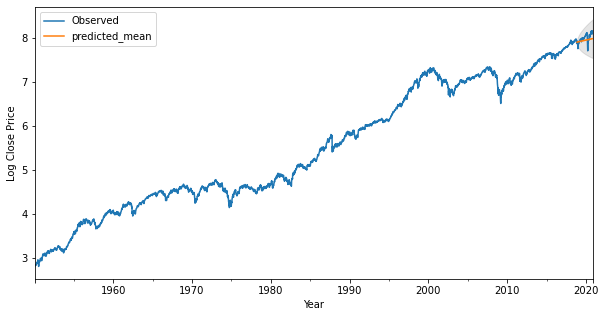

In [259]:
futureDF_forecast, next_periods_ci = forecast_with_sarimax(weekly_data.set_index("Date")['Log_Close'], 104, order=order,
                                                           seasonal_order=seasonal_order, offset = 0)

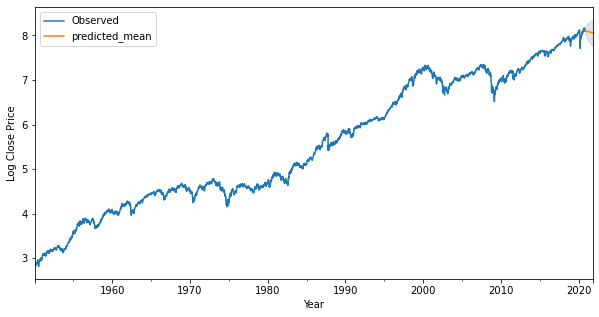

In [260]:
futureDF_forecast, next_periods_ci = forecast_with_sarimax(weekly_data.set_index("Date")['Log_Close'], 52, order=order,
                                                           seasonal_order=seasonal_order, forcast_next = True)

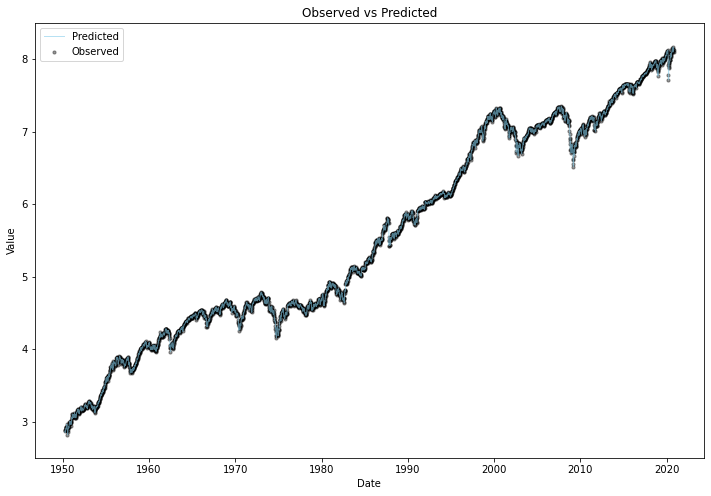

In [261]:
sarima_obs_vs_pred(weekly_data.set_index("Date")['Log_Close'], order, seasonal_order)

## Prophet (weekly)

In [115]:
weekly_data_prophet = weekly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)

In [ ]:
# cutoffs = pd.to_datetime([f'{year}-01-01' for year in [i*10 + 1969 for i in range(5)]])
# weekly_data_prophet = weekly_data.rename({"Date": "ds", "Log_Close": "y"}, axis =1)
# param_grid = {
#     'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5, 1],
#     'seasonality_prior_scale': [0.005,0.01, 0.1, 0.5, 1.0],
#     'changepoint_range': [0.8, 0.85, 0.9, 0.95]
# }

# tuning_results = hyper_tune_prophet_model(weekly_data_prophet, cutoffs, param_grid)
# tuning_results.to_csv("prophet_tuning_weekly.csv")

In [ ]:
# tuning_results.sort_values(by="mse")

In [118]:
m = Prophet(changepoint_range = 0.85, seasonality_prior_scale = 0.01, changepoint_prior_scale=0.1)
m.fit(weekly_data_prophet)
df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days')
df_p = performance_metrics(df_cv, rolling_window=1)
df_p['mse'].values[0]

14:56:48 - cmdstanpy - INFO - Chain [1] start processing
14:56:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/5 [00:00<?, ?it/s]

14:56:52 - cmdstanpy - INFO - Chain [1] start processing
14:56:53 - cmdstanpy - INFO - Chain [1] done processing
14:56:54 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:56 - cmdstanpy - INFO - Chain [1] start processing
14:56:57 - cmdstanpy - INFO - Chain [1] done processing
14:56:58 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:03 - cmdstanpy - INFO - Chain [1] done processing


0.027678295129481008

14:56:26 - cmdstanpy - INFO - Chain [1] start processing
14:56:30 - cmdstanpy - INFO - Chain [1] done processing


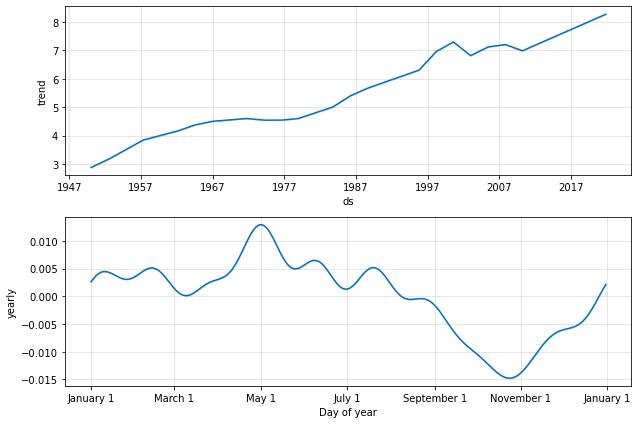

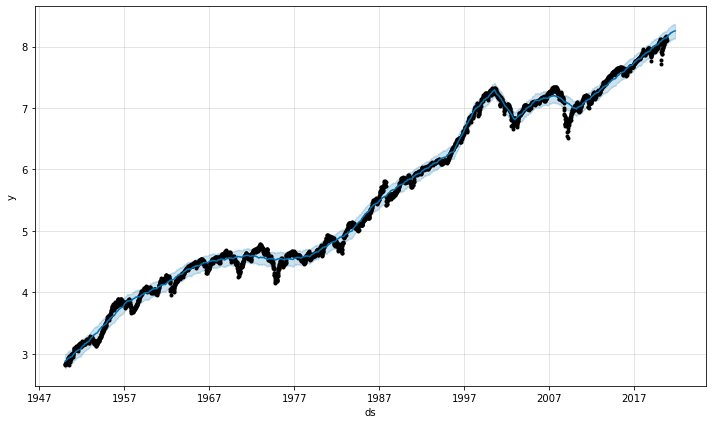

In [117]:
m = Prophet(changepoint_range = 0.85, seasonality_prior_scale = 0.01, changepoint_prior_scale=0.1)
m.fit(weekly_data_prophet)
future_dates = m.make_future_dataframe(periods=52, freq='W-MON')
forecast = m.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot_components(forecast);
m.plot(forecast);

## exog variables

In [269]:
weekly_data["Lag_Volume"] = [weekly_data["Volume"][0]] + weekly_data["Volume"][:-1].tolist()
sarima_model = SARIMAX(weekly_data['Log_Close'], exog=weekly_data['Lag_Volume'], order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              Log_Close   No. Observations:                 3696
Model:             SARIMAX(2, 0, 0)x(1, 1, [1, 2], 4)   Log Likelihood                7740.316
Date:                                Wed, 17 Apr 2024   AIC                         -15466.632
Time:                                        17:28:40   BIC                         -15423.134
Sample:                                    01-01-1970   HQIC                        -15451.150
                                         - 01-01-1970                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Lag_Volume -5.453e-12   3.55e-13    -15.376      0.000   -6.15e-12   -4.76e-12
ar.L1          0.7564   3.93e-24   1.93e+23      0.000       0.756       0.756
ar.L2         -0.0706   2.74e-24  -2.57e+22      0.000      -0.071      -0.071
ar.S.L4       -0.0048   1.87e-24  -2.54e+21      0.000      -0.005      -0.005
ma.S.L4       -0.0738   1.88e-24  -3.93e+22      0.000      -0.074      -0.074
ma.S.L8        0.0102   1.26e-25   8.06e+22      0.000       0.010       0.010
sigma2         0.0009    7.5e-22   1.25e+18      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              6452.50
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.22   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.78e+41. Standard errors may be unstable.
"""

In [271]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data['Lag_Volume'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.012340809827269263, AIC: -8825.000788413246


In [272]:
president_party_df = generate_president_party_dataset()
president_party_df['Democrat'] = president_party_df['Presidential Party'] == 'Democrat'
president_party_df['Republican'] = president_party_df['Presidential Party'] == 'Republican'
president_party_df['Democrat'] = president_party_df['Democrat'].astype(int)
president_party_df['Republican'] = president_party_df['Republican'].astype(int)

weekly_data_enriched = weekly_data.merge(president_party_df[['Date', 'Years Until Next US Election', 
                                                                 'Democrat', 'Republican']],
                                             left_on='Date', right_on='Date', how='left')
weekly_data_enriched["Democrat_Log_close"] = weekly_data_enriched["Democrat"] * weekly_data_enriched['Log_Close']
weekly_data_enriched["Election_year"] = (weekly_data_enriched["Years Until Next US Election"] == 0)*1
weekly_data_enriched["Election_year_Log_close"] = weekly_data_enriched["Election_year"] * weekly_data_enriched['Log_Close']

In [276]:
sarima_model = SARIMAX(weekly_data_enriched['Log_Close'], exog=weekly_data_enriched['Election_year'],
                       order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8567.608
Date:                                      Wed, 17 Apr 2024   AIC                         -17117.217
Time:                                              17:32:00   BIC                         -17061.301
Sample:                                                   0   HQIC                        -17097.314
                                                     - 3696                                         
Covariance Type:                                        opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Election_year     0.0043      0.005      0.882      0.378      -0.005       0.014
ar.L1             0.8734      0.011     82.762      0.000       0.853       0.894
ar.L2             0.0100      0.014      0.696      0.487      -0.018       0.038
ar.L3             0.0954      0.010      9.580      0.000       0.076       0.115
ma.S.L4          -1.9512      0.013   -152.717      0.000      -1.976      -1.926
ma.S.L8           0.9564      0.028     34.537      0.000       0.902       1.011
ma.S.L12         -0.0452      0.028     -1.611      0.107      -0.100       0.010
ma.S.L16          0.0406      0.013      3.155      0.002       0.015       0.066
sigma2            0.0006   5.47e-06    101.864      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  23.09   Jarque-Bera (JB):             24518.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.14   Skew:                            -1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [277]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data_enriched['Election_year'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.008032643969794948, AIC: -9771.923930309707


In [278]:
sarima_model = SARIMAX(weekly_data_enriched['Log_Close'], exog=weekly_data_enriched['Election_year_Log_close'],
                       order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8559.555
Date:                                      Wed, 17 Apr 2024   AIC                         -17101.110
Time:                                              17:33:21   BIC                         -17045.194
Sample:                                                   0   HQIC                        -17081.207
                                                     - 3696                                         
Covariance Type:                                        opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Election_year_Log_close     0.0006      0.001      0.808      0.419      -0.001       0.002
ar.L1                       0.8212      0.010     78.986      0.000       0.801       0.842
ar.L2                       0.1100      0.014      7.645      0.000       0.082       0.138
ar.L3                       0.0390      0.010      4.059      0.000       0.020       0.058
ma.S.L4                    -1.9700      0.013   -146.290      0.000      -1.996      -1.944
ma.S.L8                     1.0030      0.029     34.891      0.000       0.947       1.059
ma.S.L12                   -0.0721      0.028     -2.612      0.009      -0.126      -0.018
ma.S.L16                    0.0398      0.012      3.247      0.001       0.016       0.064
sigma2                      0.0005   5.36e-06    101.984      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  61.56   Jarque-Bera (JB):             27284.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.12   Skew:                            -1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [279]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data_enriched['Election_year_Log_close'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.00874152046096532, AIC: -9761.972694263322


In [280]:
sarima_model = SARIMAX(weekly_data_enriched['Log_Close'], exog=weekly_data_enriched['Years Until Next US Election'],
                       order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8574.379
Date:                                      Wed, 17 Apr 2024   AIC                         -17130.758
Time:                                              17:34:36   BIC                         -17074.843
Sample:                                                   0   HQIC                        -17110.856
                                                     - 3696                                         
Covariance Type:                                        opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Years Until Next US Election    -0.0009      0.002     -0.499      0.618      -0.005       0.003
ar.L1                            0.8756      0.011     82.492      0.000       0.855       0.896
ar.L2                            0.0609      0.014      4.241      0.000       0.033       0.089
ar.L3                            0.0418      0.010      4.395      0.000       0.023       0.061
ma.S.L4                         -1.9762      0.013   -148.262      0.000      -2.002      -1.950
ma.S.L8                          0.9949      0.029     34.153      0.000       0.938       1.052
ma.S.L12                        -0.0471      0.029     -1.647      0.100      -0.103       0.009
ma.S.L16                         0.0289      0.013      2.266      0.023       0.004       0.054
sigma2                           0.0006   5.35e-06    102.976      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  22.25   Jarque-Bera (JB):             25313.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [281]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data_enriched['Years Until Next US Election'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.008122455179582657, AIC: -9770.021391298826


In [282]:
sarima_model = SARIMAX(weekly_data_enriched['Log_Close'], exog=weekly_data_enriched['Democrat'],
                       order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8605.239
Date:                                      Wed, 17 Apr 2024   AIC                         -17192.478
Time:                                              17:35:49   BIC                         -17136.562
Sample:                                                   0   HQIC                        -17172.575
                                                     - 3696                                         
Covariance Type:                                        opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Democrat       0.0072      0.008      0.905      0.365      -0.008       0.023
ar.L1          0.9135      0.010     88.344      0.000       0.893       0.934
ar.L2          0.0372      0.014      2.653      0.008       0.010       0.065
ar.L3          0.0344      0.009      3.724      0.000       0.016       0.052
ma.S.L4       -1.9778      0.013   -149.739      0.000      -2.004      -1.952
ma.S.L8        0.9964      0.029     34.333      0.000       0.940       1.053
ma.S.L12      -0.0465      0.028     -1.637      0.102      -0.102       0.009
ma.S.L16       0.0283      0.013      2.244      0.025       0.004       0.053
sigma2         0.0005   5.15e-06    104.728      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):             26959.80
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [283]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data_enriched['Democrat'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.007981529921619915, AIC: -9775.541019545548


In [284]:
sarima_model = SARIMAX(weekly_data_enriched['Log_Close'], exog=weekly_data_enriched['Democrat_Log_close'],
                       order=order, seasonal_order=seasonal_order).fit()
# sarima_forecast = sarima_model.get_forecast(steps=12)
display(sarima_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                           
====================================================================================================
Dep. Variable:                                    Log_Close   No. Observations:                 3696
Model:             SARIMAX(3, 0, 0)x(0, 2, [1, 2, 3, 4], 4)   Log Likelihood                8582.131
Date:                                      Wed, 17 Apr 2024   AIC                         -17146.262
Time:                                              17:37:05   BIC                         -17090.347
Sample:                                                   0   HQIC                        -17126.360
                                                     - 3696                                         
Covariance Type:                                        opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Democrat_Log_close     0.0040      0.001      3.227      0.001       0.002       0.006
ar.L1                  0.8763      0.011     83.082      0.000       0.856       0.897
ar.L2                  0.0919      0.014      6.371      0.000       0.064       0.120
ar.L3                  0.0005      0.010      0.056      0.956      -0.018       0.019
ma.S.L4               -1.8958      0.013   -140.465      0.000      -1.922      -1.869
ma.S.L8                0.8648      0.027     31.564      0.000       0.811       0.918
ma.S.L12              -0.0049      0.027     -0.180      0.857      -0.058       0.048
ma.S.L16               0.0370      0.013      2.924      0.003       0.012       0.062
sigma2                 0.0006   5.56e-06    100.028      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                  13.90   Jarque-Bera (JB):             27177.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [285]:
mse, mse_mean, aic, aic_mean = cross_validate_sarima(weekly_data, cutoffs, order, seasonal_order, prediction_period = 52,
                      y_col= 'Log_Close', exog=weekly_data_enriched['Democrat_Log_close'])
print(f"mse: {mse_mean}, AIC: {aic_mean}")

mse: 0.005988009919175611, AIC: -9744.354308588103
